In [3]:
# import necessary libraries
import h5py

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow as tf

# Utility Functions

In [4]:
# function to plot 10 images side-by-side from an array
def plot_images(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Loading Data

Check the data in `.h5` file inspecting for its keys and type of items:

In [5]:
file_path = 'data/train_images.h5'

with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print("key:", key)
        print("item type:", type(f[key]))

key: train_images
item type: <class 'h5py._hl.dataset.Dataset'>


We can see that `train_images` is the only key available, and the data type is a `Dataset`.

We can read and store `train_images` data in the `train_data` variable as a NumPy array:

In [6]:
with h5py.File(file_path, 'r') as f:
    train_data = f['train_images'][:]

print("dataset type:", type(train_data))

dataset type: <class 'numpy.ndarray'>


Check the shape of `train_data`:

In [7]:
print("array shape", train_data.shape)

array shape (50000, 128, 128, 1)


The data shape is compliant with the information in test description (50k images, 128x128 pixels and 1 color channel).

We can check the array range as well:

In [8]:
print("array range", train_data.min(), train_data.max())

array range 0 1


The range of values is from 0 to 1, also compliant with test description.

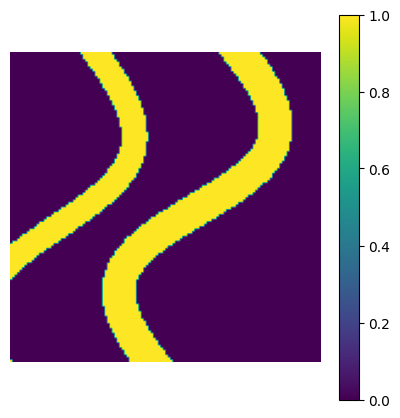

In [9]:
# visualizing one image from dataset
plt.figure(figsize=(5,5))

plt.colorbar(plt.imshow(train_data[20]))
plt.axis('off')

plt.show()

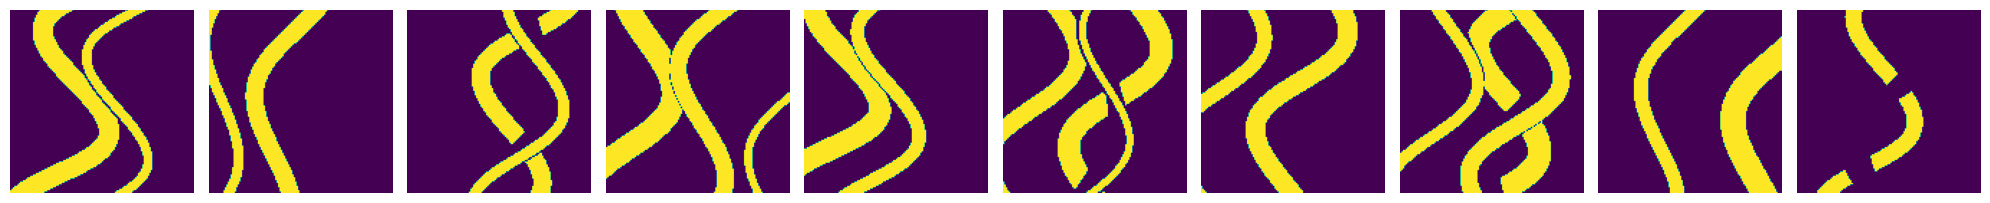

In [10]:
# visualizing 10 images
plot_images(train_data[:10])

# Resizing the data

I've decided to lower image resolution by 1/4, i.e. 32x32 pixels, to reduce computation time while training.

In [11]:
resized_train_data = keras.preprocessing.image.smart_resize(
    train_data, (32,32), interpolation='bilinear'
)

Check that `resized_train_data` shape and range have expected values:

In [12]:
print("array shape", resized_train_data.shape)
print("array range", resized_train_data.min(), resized_train_data.max())

array shape (50000, 32, 32, 1)
array range 0 1


Visualize the images after transformation:

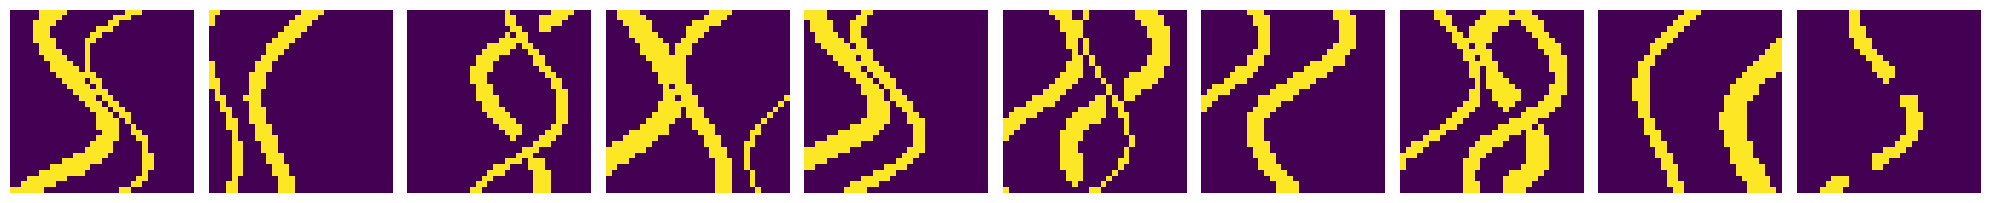

In [13]:
plot_images(resized_train_data[:10])

We can see that the main features of the images were preserved, so training results won't have significant impact from the resizing.

# Variational Autoencoders (VAEs)

Variational Autoencoders (VAEs) are a type of generative model that combines the principles of variational inference and autoencoders. VAEs are designed to learn a latent representation of input data that can be used to generate new, similar data samples. They are widely used in applications like image generation, anomaly detection, and data compression.

A VAE consists of two main components: an encoder and a decoder. The encoder maps input data (e.g., images) into a latent space by learning a probabilistic distribution over the latent variables, usually modeled as a Gaussian distribution with mean (`z_mean`) and variance (`z_log_var`). The decoder then reconstructs the original data from a sampled point in this latent space, effectively generating new data points.

## Sampling Class

The Sampling class is responsible for introducing regularization into the latent space. This class samples a latent vector `z` using `z_mean` and `z_log_var` provided by the encoder.

In a VAE, the encoder outputs `z_mean` and `z_log_var`, which define a Gaussian distribution. The Sampling class is used to draw samples from this distribution. These samples, represented by the latent vector `z`, are then passed to the decoder for reconstruction. The Sampling class is critical because it enables the model to generate new data points by sampling from the latent space.

This sampling process is also integral to calculating the Kullback–Leibler (KL) divergence loss, which measures how much the learned distribution (defined by `z_mean` and `z_log_var`) deviates from a standard normal distribution. The KL loss is combined with the reconstruction loss during training, encouraging the encoder to produce a latent space where the data points are organized in a way that approximates a Gaussian distribution.

In [14]:
# sample vectors from the latent space
class Sampling(layers.Layer):
    """"Uses (z_mean, z_log_var) to sample z, the vector enconding an image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # reparametrization trick

# VAE Models

## Convolutional + Dense (Fully Connected) VAE

In this implementation, we combine convolutional and dense layers in our VAE to leverage both spatial awareness and global pattern recognition. Convolutional layers are adept at capturing local features in the input data, while dense layers enable the model to identify broader, more abstract patterns. This hybrid approach not only enhances the model's ability to generate realistic and semantically meaningful images but also reduces the number of parameters compared to fully connected VAEs, improving computational efficiency.

### Encoder

In [15]:
# define the encoder network
latent_dim = 100

encoder_inputs = tf.keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [16]:
# create the encoder model
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4096)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        262,208 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 100)            │          6,500 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 100)            │          6,500 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 100)            │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 294,024 (1.12 MB)

 Trainable params: 294,024 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [17]:
# define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [18]:
# create the decoder model
decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │         413,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 469,377 (1.79 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

### Model

In [19]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.regularization_loss = keras.metrics.Mean(name="regularization_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.regularization_loss]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # KL divergence loss
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            mean_loss = tf.reduce_mean(tf.square(z_mean))
            cov_loss = tf.reduce_mean(tf.exp(z_log_var)- z_log_var - 1)
            regularization_loss = mean_loss + cov_loss
            total_loss = reconstruction_loss + kl_loss + regularization_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.regularization_loss.update_state(regularization_loss)
        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
                "regularization_loss": self.regularization_loss.result()
            }

In [20]:
# define the VAE model
vae = VAE(encoder, decoder)

# compile the VAE model
vae.compile(optimizer=keras.optimizers.Adam())

### Training

In [21]:
# train the VAE model
resized_train_data = resized_train_data.astype("float32")

vae.fit(resized_train_data, epochs=50, batch_size=32)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - kl_loss: 32.7226 - loss: 295.2825 - reconstruction_loss: 261.9054 - regularization_loss: 0.6545
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kl_loss: 47.6436 - loss: 135.6959 - reconstruction_loss: 87.0995 - regularization_loss: 0.9529
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 44.0518 - loss: 113.9171 - reconstruction_loss: 68.9842 - regularization_loss: 0.8810
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - kl_loss: 40.8076 - loss: 100.4739 - reconstruction_loss: 58.8502 - regularization_loss: 0.8162
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - kl_loss: 38.6637 - loss: 92.0133 - reconstruction_loss: 52.5763 - regularization_loss: 0.7733
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 37.4390 - loss: 86.3913 - reconstruction_loss: 48.2035 - regularization_loss: 0.7488
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - kl_loss: 36.5688 - loss: 82.1741 - 

### Saving model

In [22]:
# save the VAE model weights
vae.save_weights("models/vae_dim100_conv_dense.weights.h5")

### Predicting new images

In [23]:
# generate new images from random latent vectors
num_images = 30  # number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


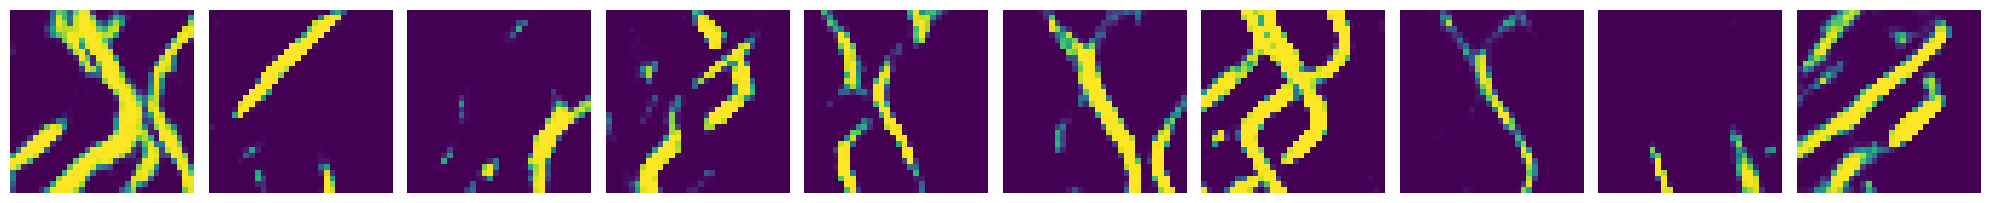

In [24]:
plot_images(generated_images[:10])

### Interpolating Different Latent Spaces

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


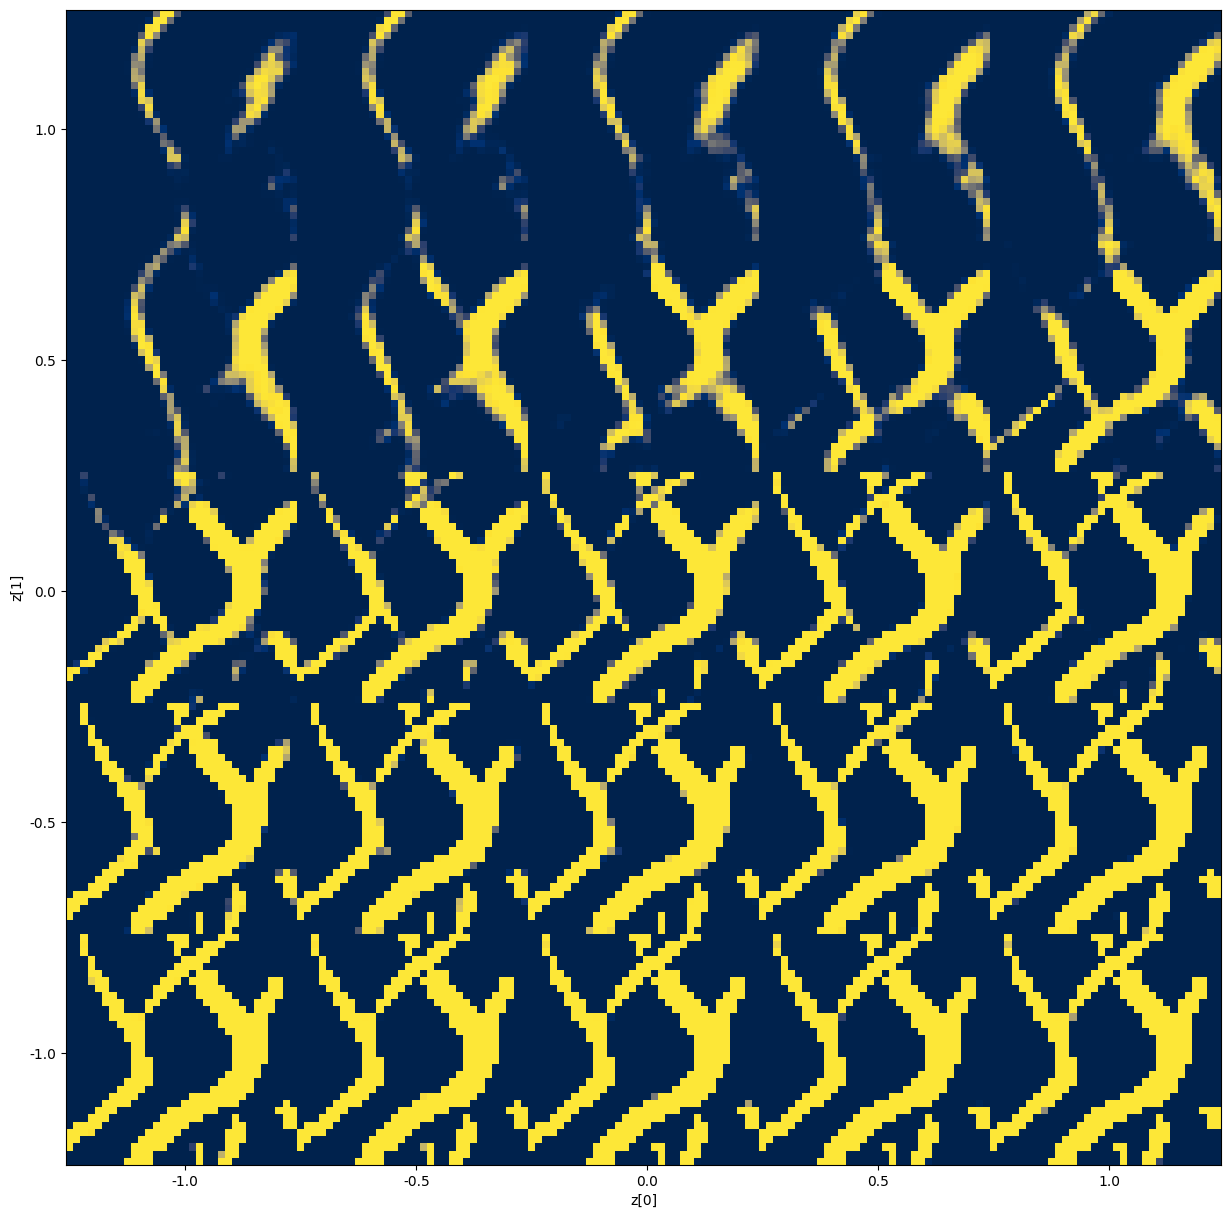

In [25]:
def plot_latent_space(vae, n=5, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    initial_latent_vector = tf.random.normal(shape=(1, latent_dim))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = initial_latent_vector + 0.25 * np.mean(initial_latent_vector)
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            initial_latent_vector = z_sample
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="cividis")
    plt.show()


plot_latent_space(vae)

From the plot we can see that generated images transit smoothly for small changes in the latent space. This implies that latent space is regularized, as we wanted.

## Fully Convolutional VAE (FCVAE)

A FCVAE is composed entirely of convolutional layers, which ensures that the spatial properties of the input data are preserved throughout the network. This architecture excels in tasks where understanding the spatial relationships within an image is crucial, as it can effectively label pixels in relation to their spatial context.

However, the focus on local receptive fields in fully convolutional networks can limit their ability to capture broader, global patterns within the data. This constraint can impact the network's capacity to generate coherent and diverse images, as it may struggle to integrate information across the entire image. Consequently, while FCVAEs maintain strong spatial consistency, they may produce outputs that lack the variety and global coherence seen in models that also incorporate dense layers.

### Encoder

In [26]:
# define the encoder network
latent_dim = 10

encoder_inputs = tf.keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, strides=2, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, 3, strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(latent_dim, 1, activation="relu")(x)
z_mean = layers.GlobalAveragePooling2D(name="z_mean")(x) # Global average pooling is used to reduce the spatial dimensions of the output.
z_log_var = layers.GlobalAveragePooling2D(name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

In [27]:
# create the encoder model
encoder_convolutional = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_convolutional.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 32)     │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 10)       │            650 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean                    │ (None, 10)             │              0 │ conv2d_5[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var                 │ (None, 10)             │              0 │ conv2d_5[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 56,394 (220.29 KB)

 Trainable params: 56,394 (220.29 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [28]:
# define the decoder network
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Reshape((1, 1, latent_dim))(decoder_inputs)
x = layers.Conv2DTranspose(32, 2, strides=1, activation="relu", padding="valid")(x)
x = layers.Conv2DTranspose(16, 2, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, 2, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(4, 2, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(2, 2, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 2, strides=1, activation="sigmoid", padding="same")(x)

In [29]:
# create the decoder model
decoder_convolutional = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder_convolutional.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 1, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 2, 2, 32)            │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 4, 4, 16)            │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 8, 8, 8)             │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 16, 16, 4)           │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 2)           │              34 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 1)           │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,071 (15.90 KB)

 Trainable params: 4,071 (15.90 KB)

 Non-trainable params: 0 (0.00 B)

### Model

In [30]:
# define the VAE model
vae_convolutional = VAE(encoder_convolutional, decoder_convolutional)

# compile the VAE model
vae_convolutional.compile(optimizer=keras.optimizers.Adam())

### Training

In [31]:
# train the VAE model
vae_convolutional.fit(resized_train_data, epochs=30, batch_size=32)

Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - kl_loss: 1.2934e-04 - loss: 620.3342 - reconstruction_loss: 620.3341 - regularization_loss: 2.5868e-05
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 0.3736 - loss: 477.7975 - reconstruction_loss: 477.3491 - regularization_loss: 0.0747
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - kl_loss: 2.5307 - loss: 451.8281 - reconstruction_loss: 448.7913 - regularization_loss: 0.5061
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - kl_loss: 5.4804 - loss: 434.7589 - reconstruction_loss: 428.1823 - regularization_loss: 1.0961
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - kl_loss: 6.7551 - loss: 428.3119 - reconstruction_loss: 420.2058 - regularization_loss: 1.3510
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 7.9713 - loss: 424.7930 - reconstruction_loss: 415.2272 - regularization_loss: 1.5943
Epoch 7/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 8.8480 - loss: 42

### Saving model

In [32]:
# save the VAE model weights
vae.save_weights("models/vae_dim10_fully_conv.weights.h5")

### Predicting new images

In [33]:
# generate new images from random latent vectors
num_images = 10  # number of images to generate
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
generated_images = vae_convolutional.decoder.predict(random_latent_vectors)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


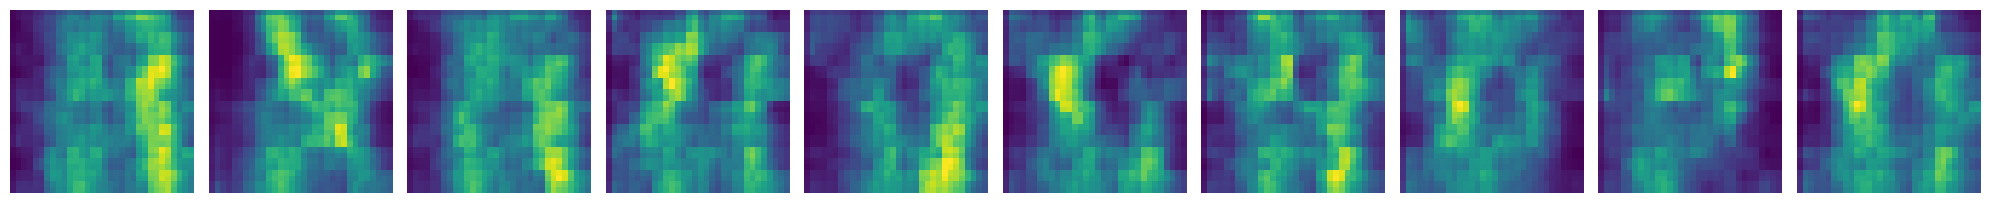

In [34]:
plot_images(generated_images)

# Conclusion

The convolutional + dense VAE, with a 100-dimensional latent space, was able to generate reconstructed images of meander-type geological channels that closely resemble the original data. Despite this success, the reconstructions lacked fine-grained details, and some fluctuations were evident—limitations commonly observed in VAEs. The described issues could potentially be mitigated by further experimentation, adjustments to the architecture of the encoder and decoder, extended training durations, or by fine-tuning the balance of the loss function's components. However, the constraints of limited computational resources and time prevented the exploration of these possibilities.

The fully convolutional VAE presented more significant challenges, especially when attempting to generate new images from randomly sampled latent vectors. The design of the fully convolutional model proved particularly complex, requiring careful consideration of the number of layers, filter counts, kernel sizes, and strides. In my attempts, the best results I've achieved so far was with a 10-dimensional latent space. Those results resemble some of the original data but evidently have a lot more of fluctuations when comparing with the convolutional + dense VAE results. As described for the issues in convolutional + dense VAE, those problems could potentially be solved with more investigation.

Despite the problems mentioned, this challenge was very exciting to work with and I've learned some interesting topics in ML that I didn't know about. I appreciate the opportunity to work on this and look forward to future endeavors!